In [4]:
import numpy as np # linear algebra
import pandas as pd

%matplotlib inline

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter
import re
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')


sns.set(style="white", context="talk")

In [16]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [43]:
from keras.models import load_model

In [5]:
import os
os.chdir("Desktop")

In [11]:
train = pd.read_csv('train.csv')

In [12]:
train.tail(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [13]:
test = pd.read_csv('test.csv')

In [14]:
trainlist = train["comment_text"].tolist()
testlist = test["comment_text"].tolist()
for i, c in enumerate(trainlist):
    trainlist[i] = re.sub('[^a-zA-Z ?!]+', '', str(trainlist[i]).lower())
for i, c in enumerate(testlist):
    testlist[i] = re.sub('[^a-zA-Z ?!]+', '', testlist[i].lower())
train["comment_text"] = trainlist
test["comment_text"] = testlist

In [15]:
test.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then youll ...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i dont anonymously edit articles at all


In [17]:
word_counter = {}
CATEGORIES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])

for categ in CATEGORIES:
    d = Counter()
    train[train[categ] == 1]['comment_text'].apply(lambda t: d.update(clean_text(t).split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

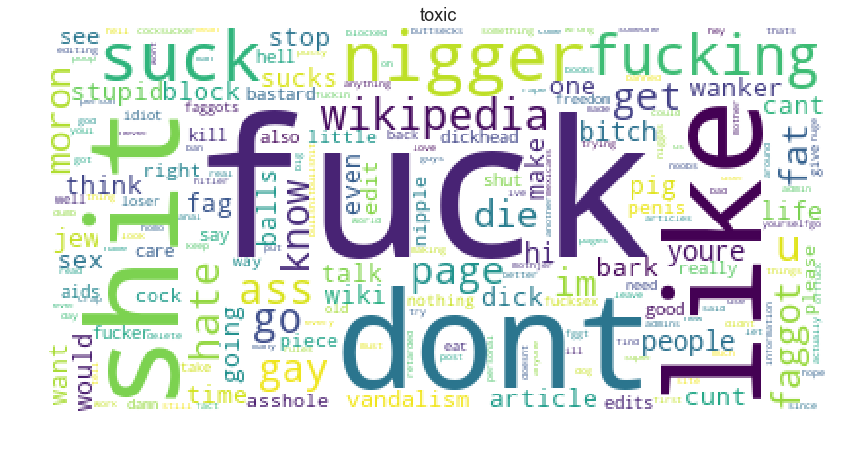

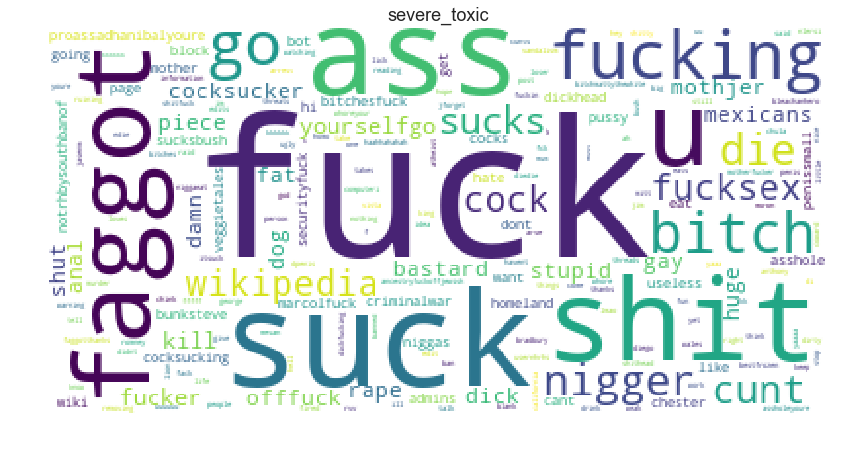

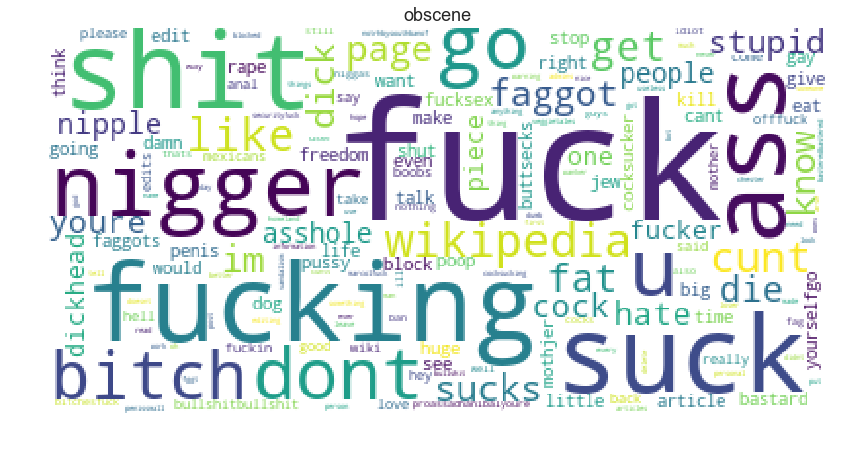

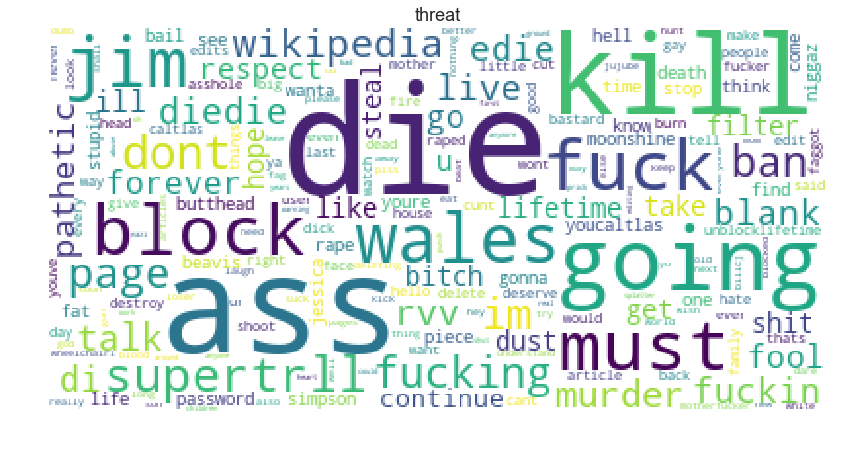

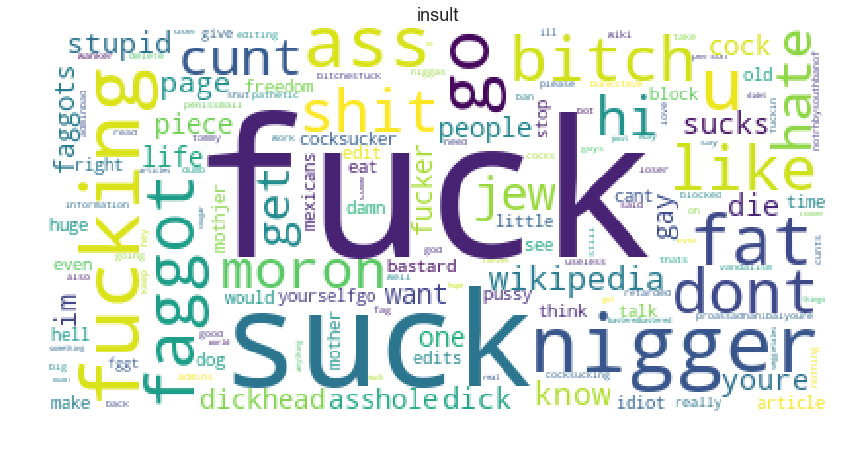

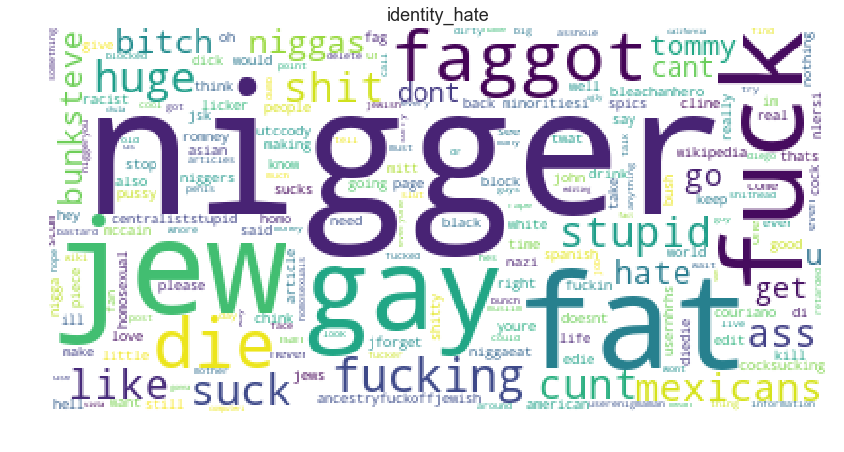

In [20]:
for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='white',
          max_words=200,
          random_state=1
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(14, 12))
    plt.title(w)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

In [10]:
train["comment_text"] = train["comment_text"].fillna("no comment")
test["comment_text"] = test["comment_text"].fillna("no comment")
X_train = train["comment_text"].str.lower()
X_test = test["comment_text"].str.lower()

In [33]:
y = train[CATEGORIES].values

In [22]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
tokenized_train = tokenizer.texts_to_sequences(X_train)
tokenized_test = tokenizer.texts_to_sequences(X_test)

In [25]:
sent_train = [len(i) for i in X_train]

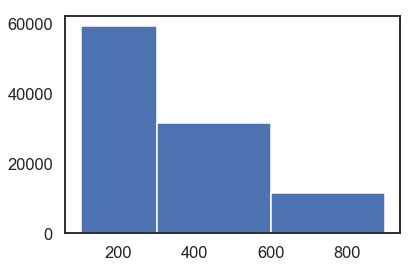

In [28]:
plt.hist(sent_train,bins=[100,300,600,900] )
plt.show()

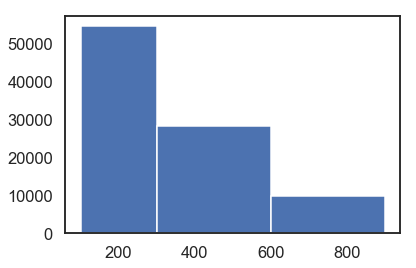

In [29]:
sent_test = [len(i) for i in X_test]
plt.hist(sent_test,bins=[100,300,600,900] )
plt.show()

In [31]:
maxlen = 300
X_tr = pad_sequences(tokenized_train, maxlen=maxlen)
X_te = pad_sequences(tokenized_test, maxlen=maxlen)

In [35]:
inputlayer = Input(shape=(maxlen, )) 
embed_size = 128
embedlayer = Embedding(max_features, embed_size)(inputlayer)
LSTMlayer = LSTM(50, return_sequences=True,name='lstm_layer')(embedlayer)
LSTMlayer = GlobalMaxPool1D()(LSTMlayer)
LSTMlayer = Dropout(0.2)(LSTMlayer)
LSTMlayer = Dense(10, activation="relu")(LSTMlayer)
LSTMlayer = Dropout(0.1)(LSTMlayer)
LSTMlayer = Dense(6, activation="sigmoid")(LSTMlayer)



In [36]:
model = Model(inputs=inputlayer, outputs=LSTMlayer)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


batch_size = 50
epochs = 3
model.fit(X_tr,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model.summary()


Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 1488s 10ms/step - loss: 0.0981 - acc: 0.9692 - val_loss: 0.0527 - val_acc: 0.9810
Epoch 2/3
143613/143613 [==============================] - 1466s 10ms/step - loss: 0.0516 - acc: 0.9808 - val_loss: 0.0522 - val_acc: 0.9813
Epoch 3/3
143613/143613 [==============================] - 1500s 10ms/step - loss: 0.0464 - acc: 0.9825 - val_loss: 0.0511 - val_acc: 0.9816
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 300, 50)           35800     
________________________________________________________________

In [41]:
model.save('toxic_model.h5')

In [44]:
model = load_model('toxic_model.h5')

In [45]:
y_pred = model.predict(X_te,batch_size=50,verbose=1)

153164/153164 [==============================] - 349s 2ms/step


In [46]:
submission = pd.read_csv('sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission.csv', index=False)

